In [23]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

import gpytorch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel



In [24]:
# GP class for regression
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# GP class for classification
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# function to optimize parameters of the classification GP - 
def train_cls_gp(model, likelihood, train_x, training_iter):
   # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, likelihood.transformed_targets).sum()
        loss.backward()
        if i - 1 == training_iter:
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                model.covar_module.base_kernel.lengthscale.mean().item(),
                model.likelihood.second_noise_covar.noise.mean().item()
            ))
        optimizer.step()

    return model, likelihood

# function to optimize parameters of the regression GP -
def train_reg_gp(model, likelihood, train_x, train_y, training_iter):
   # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if i - 1  == training_iter:
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                model.covar_module.base_kernel.lengthscale.item(),
                model.likelihood.noise.item()
            ))
        optimizer.step()

    return model, likelihood 

In [25]:
init_points = 9
# generates training data
def gen_data(num_data, seed = 2024):
    torch.random.manual_seed(seed)

    x = torch.randn(num_data,1)
    y = torch.randn(num_data,1)

    # u = torch.rand(1)
    data_fn_obj = lambda x,y: torch.cos(2*x)*torch.cos(y) + torch.sin(x) # toy function
    latent_fn_obj = data_fn_obj(x, y)
    z_obj = latent_fn_obj.squeeze()
    data_fn_cnt = lambda x, y: torch.cos(x)*torch.cos(y) - torch.sin(x)*torch.sin(y)
    latent_fn_cnt = data_fn_cnt(x, y)
    z_cnt = torch.heaviside(latent_fn_cnt - 0.2, torch.zeros(latent_fn_cnt.shape)).long().squeeze()
    return torch.cat((x,y),dim=1), z_obj, z_cnt, data_fn_obj, data_fn_cnt

# generate training data - y= objective values, c=class label
train_x, train_y, train_c, genfn_obj, genfn_cnt = gen_data(init_points)

#initialize likelihood and model - regression
reg_likelihood = gpytorch.likelihoods.GaussianLikelihood()
reg_model = ExactGPModel(train_x, train_y, reg_likelihood)

# initialize likelihood and model - we let the DirichletClassificationLikelihood compute the targets for us
cls_likelihood = DirichletClassificationLikelihood(train_c, learn_additional_noise=True)
cls_model = DirichletGPModel(train_x, cls_likelihood.transformed_targets, cls_likelihood, num_classes=cls_likelihood.num_classes)

# Train regression and classification model
training_iter = 50
print("Training Regression model")
reg_model, reg_likelihood = train_reg_gp(reg_model, reg_likelihood, train_x, train_y, training_iter)
print("Training Classification model")
cls_model, cls_likelihood = train_cls_gp(cls_model, cls_likelihood, train_x, training_iter)

Training Regression model
Training Classification model


In [26]:
# test data generate - uniform across [-3, 3] x [-3, 3]
# test_d1 = np.linspace(-3, 3, 40)
# test_d2 = np.linspace(-3, 3, 40)
test_d1 = np.random.uniform(low=-3, high=3, size=20)
test_d2 = np.random.uniform(low=-3, high=3, size=20)

test_x1_mat, test_x2_mat = np.meshgrid(test_d1, test_d2)
test_x1_mat, test_x2_mat = torch.Tensor(test_x1_mat), torch.Tensor(test_x2_mat)

test_x = torch.cat((test_x1_mat.view(-1,1), test_x2_mat.view(-1,1)), dim=1)

In [27]:
best_idx = np.argmin(train_y)
y_best = train_y[best_idx]

In [28]:
def calculate_acf(pred_mean, pred_std, y_max):
    improve = y_max - pred_mean
    z_score = np.divide(improve, pred_std + 1e-9)
    acf = np.multiply(improve, norm.cdf(z_score)) + np.multiply(pred_std, norm.pdf(z_score))
    return acf

def probability_thresholding(prob_vals, threshold):
    mask = prob_vals >= threshold
    new = torch.zeros_like(prob_vals)
    new[mask] = prob_vals[mask]
    return new

In [29]:
eval_budget = 50
num_feval = 0
bo_batch_size = 1
fail_tol = 10 # 5 successive failures lead to stopping
fail_count = 0

#store BO iteration results
obj_history = []
cnd_history = []
feasibility_history = [] 
best_y_history = [y_best]

while num_feval < eval_budget and fail_count < fail_tol:
    # prediction - objective values
    reg_model.eval()
    reg_likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        obj_pred = reg_likelihood(reg_model(test_x))
        obj_pred_means = obj_pred.loc
        obj_pred_stddev = obj_pred.stddev
    
     #prediction - class probabilities
    cls_model.eval()
    cls_likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        logit_dist = cls_model(test_x)
        logit_means = logit_dist.loc
        logit_stddevs = logit_dist.stddev

    # calculate probabilites from the logit values
    samples = logit_dist.sample(torch.Size((256,))).exp()
    class_probabilites = (samples / samples.sum(-2, keepdim=True)).mean(0)

    ei = calculate_acf(obj_pred_means, obj_pred_stddev, y_best)
    threshold_prob = probability_thresholding(class_probabilites[0], 0.5)
    con_ei = threshold_prob * ei

    # top 5 candidate points from constrained ei
    top5_ind = np.argpartition(con_ei, -bo_batch_size)[-bo_batch_size:]
    top5_ind = top5_ind[np.argsort(con_ei[top5_ind])]
    print("top candidate indices = ", top5_ind)

    #locations of top candidate points
    candidate_x = test_x[top5_ind, :]

    top5_obj_vals = genfn_obj(candidate_x[:,0], candidate_x[:, 1])
    latent_fn_cnt = genfn_cnt(candidate_x[:,0], candidate_x[:, 1])
    z_cnt = torch.heaviside(latent_fn_cnt - 0.2, torch.zeros(latent_fn_cnt.shape)).long().squeeze()

    num_feval += bo_batch_size

    #store results
    obj_history.append(top5_obj_vals)
    cnd_history.append(candidate_x)
    feasibility_history.append(z_cnt)

    #update training data set
    train_x = torch.cat((train_x, candidate_x), dim=0)
    train_y = torch.cat((train_y, top5_obj_vals), dim=0)
    train_c = torch.cat((train_c, torch.unsqueeze(z_cnt, 0)), dim=0)
    # train_c = torch.cat((train_c, z_cnt), dim=0)

    best_idx = np.argmin(train_y)
    y_best = train_y[best_idx]
    best_y_history.append(y_best)
    print("best obj value in training so far = ", y_best)
    if np.abs(best_y_history[-1]) - np.abs(best_y_history[-2]) < 0:
        fail_count += 1
    else:
        fail_count = 0

    #update test data 
    test_d1 = np.random.uniform(low=-3, high=3, size=20)
    test_d2 = np.random.uniform(low=-3, high=3, size=20)
    test_x1_mat, test_x2_mat = np.meshgrid(test_d1, test_d2)
    test_x1_mat, test_x2_mat = torch.Tensor(test_x1_mat), torch.Tensor(test_x2_mat)
    test_x = torch.cat((test_x1_mat.view(-1,1), test_x2_mat.view(-1,1)), dim=1)
    
    #update GP
    print('re-training the model')
    reg_likelihood = gpytorch.likelihoods.GaussianLikelihood()
    reg_model = ExactGPModel(train_x, train_y, reg_likelihood)
    cls_likelihood = DirichletClassificationLikelihood(train_c, learn_additional_noise=True)
    cls_model = DirichletGPModel(train_x, cls_likelihood.transformed_targets, cls_likelihood, num_classes=cls_likelihood.num_classes)

    reg_model, reg_likelihood = train_reg_gp(reg_model, reg_likelihood, train_x, train_y, 50)
    cls_model, cls_likelihood = train_cls_gp(cls_model, cls_likelihood, train_x, 50)
    print('======= BO Batch done ========')
    

top candidate indices =  tensor([260])
best obj value in training so far =  tensor(-1.2583)
re-training the model
======= BO Batch done ========
top candidate indices =  tensor([138])
best obj value in training so far =  tensor(-1.7365)
re-training the model
======= BO Batch done ========
top candidate indices =  tensor([253])
best obj value in training so far =  tensor(-1.9653)
re-training the model
======= BO Batch done ========
top candidate indices =  tensor([67])
best obj value in training so far =  tensor(-1.9653)
re-training the model
======= BO Batch done ========
top candidate indices =  tensor([334])
best obj value in training so far =  tensor(-1.9653)
re-training the model
======= BO Batch done ========
top candidate indices =  tensor([196])
best obj value in training so far =  tensor(-1.9910)
re-training the model
======= BO Batch done ========
top candidate indices =  tensor([345])
best obj value in training so far =  tensor(-1.9910)
re-training the model
======= BO Batch 

In [30]:
print("function calls = ", num_feval)
best_idx = np.argmin(train_y)
print("Optimum value of objective function = ", train_y[best_idx])
print("Optimum point location - ", train_x[best_idx, :])

function calls =  50
Optimum value of objective function =  tensor(-1.9992)
Optimum point location -  tensor([-1.5787, -0.0360])


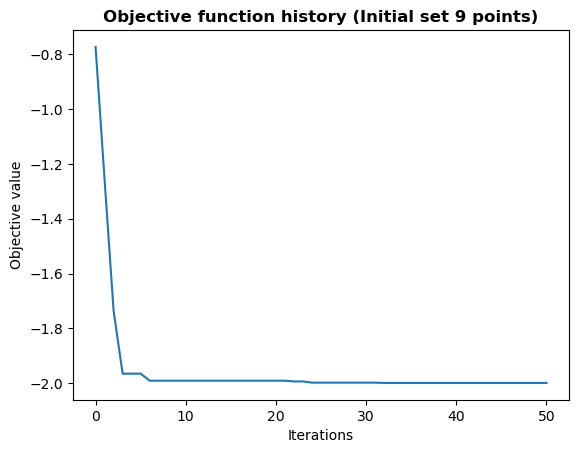

In [31]:
plt.plot(best_y_history)
plt.xlabel("Iterations")
plt.ylabel("Objective value")
plt.title("Objective function history (Initial set {0:d} points)".format(init_points), fontweight='bold')
# plt.savefig('images/replace-obj_history_init{0:d}.png'.format(init_points), dpi=300)
plt.show()

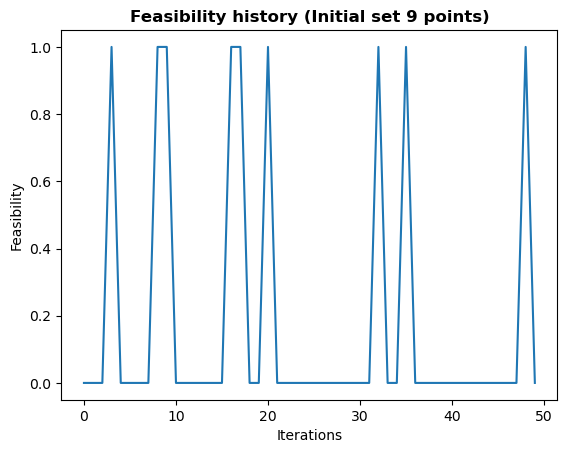

In [32]:
plt.plot(feasibility_history)
plt.xlabel('Iterations')
plt.ylabel('Feasibility')
plt.title('Feasibility history (Initial set {0:d} points)'.format(init_points), fontweight='bold')
# plt.savefig('images/unconstr-feasibility_history_init{0:d}.png'.format(init_points), dpi=300)
plt.show()

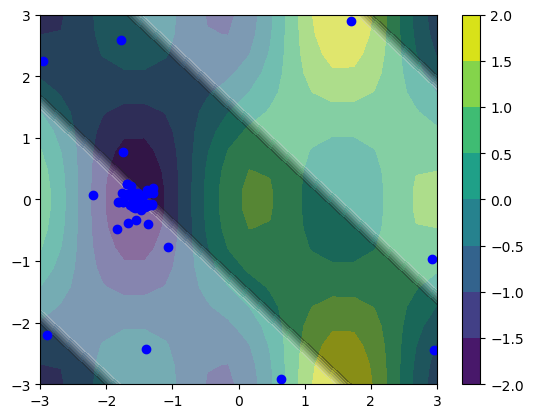

In [33]:
# plot candidate points
test_d1 = np.linspace(-3, 3, 20)
test_d2 = np.linspace(-3, 3, 20)
test_x1_mat, test_x2_mat = np.meshgrid(test_d1, test_d2)
test_x1_mat, test_x2_mat = torch.Tensor(test_x1_mat), torch.Tensor(test_x2_mat)

test_y_mat = genfn_obj(test_x1_mat, test_x2_mat)
test_lat_mat = genfn_cnt(test_x1_mat, test_x2_mat) # latent function
test_c_mat = torch.heaviside(test_lat_mat - 0.2, torch.zeros(test_lat_mat.shape))
plt.contourf(test_x1_mat.numpy(), test_x2_mat.numpy(), test_y_mat.numpy())
plt.colorbar()
plt.contourf(test_x1_mat.numpy(), test_x2_mat.numpy(), test_c_mat.numpy(), alpha=0.4, cmap='gray_r')
i=0
for item in cnd_history:
    candidate = item[0]
    plt.scatter(candidate[0], candidate[1], c='blue')
    # plt.savefig("images/replace-BO_history_init{0:d}/bo_hisotry_{1:d}.png".format(init_points, i), dpi=300)
    i+=1
plt.show()